# COLLABORATIVE FILTER RECOMMENDER SYSTEM
## BRIEF THEORETICAL BACKGROUND
Collaborative filter is one of the 3 major types of recommender systems. Collaborative filter recommender system is an intelligent system that filter out items that users might like on the basis of reactions of similar users to the item. Given a matrix whose rows are users and columns are items while the entries are ratings, also, given a user U and an item  I which the user U has not rated, the task of collaborative filtering are in 3 basic categories:
 - Find other users who are similar to U
 - Predict the rating that user U will give to item I.
 - Measure the acuracy of the rating calculated.
##### There are 2 major approaches to the task above (2 categories of collaborative filter recommender system) and they are:
 - Memory based collaborative filter.
 - Model based collaborative filter.
### Memory Based Collaborative Filter
Given 3 users A, B and C for example and 2 products such that ratings given to the products by each users are as follows:
 - Rating by A = (1, 2)
 - Ratings by B = (2, 4)
 - Rating by C = (2.5, 4)
using the memory based approach, the distance between each pair of users is estimated using any of the popular methods, such as euclidean distance, cosine distance or the Pearson's approach. The smaller the value of the distance calculated, the more similar the users are. Having established the list of similar users, the estimate of the rating that the user U will give to item I is estimated by either calculating the average of the ratings that all the similar users gave to item I or the weighted average of the ratings using the value of the similarity between each of the users and user U as the weights. The memory based collaborative filter is also either **user-based or item-based**. The approach described above is the user-based approach because interest was on fiding similar users. The focus of item-based rather is finding similr items based on ratings from users. Using the item-based, consider a user U whose rating of item I is unknown, we get the list of items that are similar to I based on vector consisting of ratings received from users. To estimate the rating to be given to item I, we select N similar items and estimate the rating based on rating score of the N similar items. The item-based approach which was developed by Amazon is proven to be faster and more stable in a system where there are more users than items. It also perform better when rating matrix is sparse because average rating received by items does not change as quickly as average change given by a user would change.
### Model Based Collaborative Filter
The model based approach adopts steps to reduce or compress sparsed user-item matrix to ruduce the amount of computational memory required. There are many approach to model based filter. Among them are matrix factorization, clustering, classification and latent class model among others which are built into appropriate python library.

## PROJECT OVERVIEW DATASET
Having fore-knowledge of how a user would react to an item is an invaluable input to the prcocess of deciding what to suggest to who. This fore-knowledge is what recommender system provides. In this project, I shall develop a collaborative filter recommender system to prodict how users would react to movies on video streaming app. The dataset used in this project is The MovieLens dataset which was downloaded from https://grouplens.org/datasets/movielens/ in October 2022. The ratings.csv file in the abridged version of the dataset. In this project, it was discovered through explorative data analysis that some movies are rarely rated while some users also rarely rate movies. As part of effort to reduce the dimension of that dataset and also for a more acurate predictions, the users who rarely rate movies as well as the movies which are rarely rated were removed, thereby reducing the shape of the dataset from 100836 by 4 to 36214 by 4. Thereafter, 11 different models which are based of various variants of collaborative filter were fitted to the dataset and the best model was selected for predictions. 

In [79]:
#importation of library and initial loading of dataset
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('ratingssmall.csv')

In [80]:
df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### EDA and Data Visualization

In [81]:
#distribution of ratings
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
data = df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
 text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 10)],
 textposition = 'auto',
 textfont = dict(color = '#000000'),
 y = data.values,
 )
# Create layout
layout = dict(title = 'Distribution Of {} book-ratings'.format(df.shape[0]),
 xaxis = dict(title = 'Rating'),
 yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [82]:
#distribution of number of ratings per movie
data = df.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Movie (Clipped at 100)',
                   xaxis = dict(title = 'Number of Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [83]:
#distribution of number of ratings per user
data = df.groupby('userId')['rating'].count().clip(upper=150)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 150,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 150)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [47]:
df.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False)[:10]

,userId,rating
413,414,2698
598,599,2478
473,474,2108
447,448,1864
273,274,1346
609,610,1302
67,68,1260
379,380,1218
605,606,1115
287,288,1055


### Data Preparation

In [48]:
#filtering out movies that received 50 ratings or less and users that gave 50 ratings or less to reduce dimension of the data and avoid  memory related issues.
min_movie_ratings = 50
filter_movies = df['movieId'].value_counts() > min_movie_ratings
filter_movies = filter_movies[filter_movies].index.tolist()

min_user_ratings = 50
filter_users = df['userId'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

filtered_df = df[(df['movieId'].isin(filter_movies)) & (df['userId'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(filtered_df.shape))

The original data frame shape:	(100836, 4)
The new data frame shape:	(36214, 4)


In [49]:
#observe that only 378 users gave ratings of 50 and above
filtered_df.groupby('userId')['rating'].count().reset_index().sort_values('rating', ascending=False).shape

(378, 2)

In [50]:
#observe that only 436 movies received 50 and above ratigs
filtered_df.groupby('movieId')['rating'].count().reset_index().sort_values('rating', ascending=False).shape

(436, 2)

### Model Fitting

In [78]:
#importation of surprise modules
from surprise import Dataset
from surprise import Reader
import numpy as np
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans,KNNWithZScore, BaselineOnly, CoClustering
from surprise.model_selection import cross_validate
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [52]:
#loading of data to surprise format
reader = Reader(line_format = 'user item rating', rating_scale=(0,5))
data = Dataset.load_from_df(filtered_df[['userId', 'movieId', 'rating']], reader)

In [53]:
#model selection
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=True)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8446  0.8444  0.8289  0.8393  0.0074  
Fit time          1.25    1.17    1.21    1.21    0.03    
Test time         0.07    0.08    0.06    0.07    0.01    


C:\Users\HP 1O3O G2\AppData\Local\Temp\ipykernel_1740\92762620.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8323  0.8248  0.8157  0.8243  0.0068  
Fit time          36.59   35.81   32.35   34.92   1.84    
Test time         1.30    1.25    0.98    1.18    0.14    


C:\Users\HP 1O3O G2\AppData\Local\Temp\ipykernel_1740\92762620.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Evaluating RMSE of algorithm SlopeOne on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8373  0.8401  0.8327  0.8367  0.0031  
Fit time          0.06    0.08    0.08    0.07    0.01    
Test time         0.68    0.66    0.66    0.66    0.01    


C:\Users\HP 1O3O G2\AppData\Local\Temp\ipykernel_1740\92762620.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Evaluating RMSE of algorithm NMF on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8650  0.8645  0.8495  0.8597  0.0072  
Fit time          1.36    2.06    1.38    1.60    0.33    
Test time         0.06    0.13    0.06    0.08    0.03    


C:\Users\HP 1O3O G2\AppData\Local\Temp\ipykernel_1740\92762620.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Evaluating RMSE of algorithm NormalPredictor on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.3458  1.3192  1.3316  1.3322  0.0108  
Fit time          0.02    0.03    0.03    0.03    0.01    
Test time         0.06    0.09    0.06    0.07    0.01    
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\HP 1O3O G2\AppData\Local\Temp\ipykernel_1740\92762620.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8235  0.8350  0.8275  0.8287  0.0048  
Fit time          0.09    0.11    0.11    0.10    0.01    
Test time         1.26    1.32    1.28    1.28    0.02    
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\HP 1O3O G2\AppData\Local\Temp\ipykernel_1740\92762620.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8800  0.8870  0.8870  0.8847  0.0033  
Fit time          0.06    0.06    0.08    0.07    0.01    
Test time         0.95    0.96    1.45    1.12    0.24    
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\HP 1O3O G2\AppData\Local\Temp\ipykernel_1740\92762620.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithMeans on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8334  0.8514  0.8297  0.8381  0.0095  
Fit time          0.09    0.08    0.09    0.09    0.01    
Test time         1.19    1.11    1.02    1.11    0.07    
Computing the msd similarity matrix...
Done computing similarity matrix.


C:\Users\HP 1O3O G2\AppData\Local\Temp\ipykernel_1740\92762620.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNWithZScore on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8286  0.8398  0.8356  0.8347  0.0046  
Fit time          0.11    0.14    0.09    0.11    0.02    
Test time         1.81    1.22    1.12    1.38    0.30    
Estimating biases using als...
Estimating biases using als...


C:\Users\HP 1O3O G2\AppData\Local\Temp\ipykernel_1740\92762620.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8322  0.8419  0.8409  0.8383  0.0044  
Fit time          0.05    0.05    0.05    0.05    0.00    
Test time         0.03    0.09    0.03    0.05    0.03    


C:\Users\HP 1O3O G2\AppData\Local\Temp\ipykernel_1740\92762620.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Evaluating RMSE of algorithm CoClustering on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8700  0.8783  0.8752  0.8745  0.0034  
Fit time          0.54    0.55    0.53    0.54    0.01    
Test time         0.03    0.03    0.05    0.04    0.01    


C:\Users\HP 1O3O G2\AppData\Local\Temp\ipykernel_1740\92762620.py:10: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.824270,34.916918,1.179380
KNNBaseline,0.828671,0.104155,1.284323
KNNWithZScore,0.834684,0.114554,1.383104
SlopeOne,0.836701,0.072929,0.663494
KNNWithMeans,0.838149,0.088566,1.107572
BaselineOnly,0.838345,0.046895,0.052077
SVD,0.839273,1.209565,0.070943
NMF,0.859680,1.597498,0.083337
CoClustering,0.874496,0.539883,0.036464


The best performing model as can be seen above is the SVDpp with RMSE value of 0.825, though it require more time/memory to train. I view of the performance, the SVDpp model is selected and used for predictions.

In [54]:
#loading of data in surprise format
reader = Reader(line_format = 'user item rating', rating_scale=(0,5))
data = Dataset.load_from_df(filtered_df[['userId', 'movieId', 'rating']], reader)

In [62]:
#fitting of the selected model to the dataset
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVDpp()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)           

RMSE: 0.8123


0.8123199914095802

### Predictions and Model Assessment

In [63]:
#building of a pandas dataframe with all the predictions
def get_Iu(uid):
    """Return the number of items rated by given user
    
    Args:
        uid: The raw id of the user.
    Returns:
        The number of items rated by the user.
    """
    
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """Return the number of users that have rated given item
    
    Args:
        iid: The raw id of the item.
    Returns:
        The number of users that have rated the item.
    """
    
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:  # item was not part of the trainset
        return 0

df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])    
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [64]:
#predictions
df.head(10)

,uid,iid,rui,est,details,Iu,Ui,err
0,304,784,2.0,3.385895,{'was_impossible': False},95,35,1.385895
1,29,904,4.5,4.489262,{'was_impossible': False},24,51,0.010738
2,153,6373,1.5,1.643229,{'was_impossible': False},65,51,0.143229
3,119,2353,3.0,3.911413,{'was_impossible': False},56,45,0.911413
4,15,2028,3.5,3.779329,{'was_impossible': False},66,130,0.279329
5,169,788,4.5,3.818458,{'was_impossible': False},90,47,0.681542
6,370,3977,3.5,2.596008,{'was_impossible': False},63,51,0.903992
7,95,4878,4.0,4.789330,{'was_impossible': False},58,73,0.789330
8,414,788,3.0,2.639629,{'was_impossible': False},315,47,0.360371
9,428,7143,3.0,3.186663,{'was_impossible': False},109,45,0.186663


In [65]:
best_predictions = df.sort_values(by='err')[:20]
worst_predictions = df.sort_values(by='err')[-20:]

In [66]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
8209,122,1213,5.0,5.000000,{'was_impossible': False},98,89,0.000000
6030,523,4973,5.0,5.000000,{'was_impossible': False},28,80,0.000000
6887,171,296,5.0,5.000000,{'was_impossible': False},40,179,0.000000
245,122,48516,5.0,5.000000,{'was_impossible': False},98,76,0.000000
3908,122,1208,5.0,5.000000,{'was_impossible': False},98,72,0.000000
1125,597,1197,5.0,5.000000,{'was_impossible': False},118,97,0.000000
3279,584,589,5.0,5.000000,{'was_impossible': False},46,122,0.000000
6418,122,50,5.0,5.000000,{'was_impossible': False},98,117,0.000000
3242,122,60069,5.0,5.000000,{'was_impossible': False},98,60,0.000000
7711,171,1136,5.0,5.000000,{'was_impossible': False},40,93,0.000000


As observed in the best_predictions above, the perfect ratings are not random guess as the Ui (number of contributors to the ratings) are much.

In [67]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
5686,34,110,0.5,3.645552,{'was_impossible': False},34,134,3.145552
5263,303,1080,1.0,4.146045,{'was_impossible': False},34,58,3.146045
67,304,36,1.0,4.164606,{'was_impossible': False},95,39,3.164606
4676,112,300,0.5,3.671459,{'was_impossible': False},37,45,3.171459
2770,51,2617,0.5,3.689684,{'was_impossible': False},74,59,3.189684
1768,112,17,0.5,3.710586,{'was_impossible': False},37,41,3.210586
2880,301,1240,0.5,3.726907,{'was_impossible': False},73,88,3.226907
3453,393,32587,0.5,3.729458,{'was_impossible': False},53,64,3.229458
5794,62,8360,1.0,4.301632,{'was_impossible': False},107,55,3.301632
1077,256,48385,0.5,3.829453,{'was_impossible': False},44,42,3.329453


Assessing the worst_predictions a little further, I will consider the very last record where user 256 gave a rating of 0.5 whereas his rating is predicted to be 4.4650386. Majority of other users gave rating between 3.5 and 5 to same movie 5618 with average of 4.115 as can be seen below. From the histogram, only one user gave that rating of 0.5 hence, the value could be considered an outlier. Hence, it can be assessed that the so called worst_prediction was as a result of only an outlier and hence has no impact on the overall acuracy of predictions. This is the same for all the "worst_predictions".

<IPython.core.display.Javascript object>


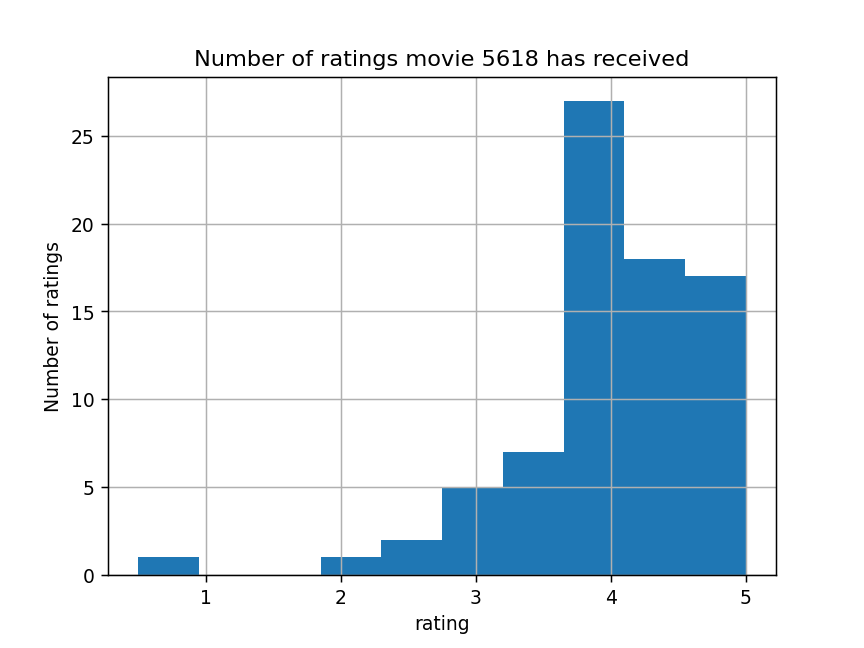

In [68]:
import matplotlib.pyplot as plt
%matplotlib notebook
filtered_df.loc[filtered_df['movieId'] == 5618]['rating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings movie 5618 has received')
plt.show();

In [69]:
filtered_df.loc[filtered_df['movieId'] == 5618]['rating'].mean()

4.115384615384615

In [70]:
filtered_df.loc[filtered_df['movieId'] == 5618]['rating'][:40]

959      5.0
1501     3.0
1650     4.5
1746     5.0
3200     5.0
3875     4.0
5750     3.5
7214     4.0
8873     5.0
9316     4.0
10257    4.5
11071    2.5
14618    4.0
15003    4.5
15183    4.0
15781    4.0
16113    4.0
16431    4.0
19773    4.5
20163    3.5
21789    4.5
22081    4.0
23989    4.5
26919    4.5
27681    5.0
27888    4.0
30330    4.0
36056    5.0
36250    3.5
37796    0.5
38079    4.5
39999    4.0
42083    4.5
42969    4.0
44871    4.0
46186    5.0
46629    3.5
47354    4.0
47775    4.0
49273    4.5
Name: rating, dtype: float64